# Nonrigorous renormalisation fixed point

## Nonrigorous polynomials

In [1]:
from numpy.polynomial.polynomial import Polynomial as Poly1
import numpy as np

In [2]:
import pickle

def pickle_poly1(g, filename):
    with open(filename, 'wb') as file:
        pickle.dump(list(g.coef), file)
        pickle.dump(g.domain, file)
        pickle.dump(g.window, file)
        
def unpickle_poly1(filename):
    with open(filename, 'rb') as file:
        coef = pickle.load(file)
        domain = pickle.load(file)
        window = pickle.load(file)
    assert (window == [-1, 1]).all(), f'{window}'
    return Poly1(coef, domain=domain, window=window)

In [3]:
def make_x(g):
    lo, hi = g.domain
    c, r = (lo+hi)/2, (hi-lo)/2
    x = Poly1([c, r], domain=[lo, hi])
    return x

In [4]:
def norm1(g):
    return np.sum(np.abs(g.coef))

In [5]:
def unit_vector(n, k):
    e = np.zeros(n)
    e[k] = 1
    return e

In [6]:
def make_basis_for(g):
    N = len(g)
    return [Poly1(unit_vector(N, k), domain=g.domain) for k in range(N)]

## Renormalisation operator

$$
T(g)(x)
= \alpha g(g(x/\alpha)).
$$

We consider even functions and therefore write $g(x)=G(X)$ with $X=x^2$.  The corresponding operator is given by

$$
U(G)(X)
= \alpha G(G(X/\alpha^2)^2).
$$

Varin variant

$$
\alpha = \frac{1}{g(1)} = \frac{1}{G(1)}.
$$

In [7]:
def T_varin(g):
    X = make_x(g)
    alpha = 1/g(1)
    Tg = alpha*g(g(X/alpha**2)**2)
    return Tg

T = T_varin

## Derivative

### Finite-difference approximation to the derivative

For a general operator $T$, we can approximate the Frechet derivative via finite differences.  For $\|h\|$ small, we take

$$
DT(g)(h)
\simeq \frac{T(g+h)-T(g)}{\|h\|}.
$$

In [8]:
def DT_approx(g):
    n = len(g)
    Tg = T(g)
    def DTg_approx(h):
        DTgh = ((T(g+eps*h)-Tg)/(eps*norm1(h))).truncate(n)
        return DTgh
    return DTg_approx

### Formal Frechet derivative

The exact Frechet derivative for the Varian variant of the even operator is given by

\begin{align}
DT(G)(H)(X)
&= \delta\alpha G(G(X/\alpha^2)^2)\\
&{}+ \alpha H(G(X/\alpha^2)^2)\\
&{}+ \alpha G'(G(X/\alpha^2)^2)2G(X/\alpha^2)H(X/\alpha^2)\\
&{}+ \alpha G'(G(X/\alpha^2)^2)2G(X/\alpha^2)G'(X/\alpha^2)(-2X/\alpha^3\delta\alpha),
\end{align}

where, since $\alpha=1/G(1)$, we have

$$
\delta\alpha = (-1/G(1)^2)H(1) = -\alpha^2 H(1).
$$

In [9]:
def DT(g):
    def DTg_varin(h):
        x = make_x(g)
        dg = g.deriv()
        alpha = 1/g((1))
        dalpha = -alpha**2*h((1))
        #
        Dg0 = dalpha*g(g(x/alpha**2)**2)
        Dg1 = alpha*h(g(x/alpha**2)**2)
        Dg2 = alpha*dg(g(x/alpha**2)**2)*2*g(x/alpha**2)*h(x/alpha**2)
        Dg3 = alpha*dg(g(x/alpha**2)**2)*2*g(x/alpha**2)*dg(x/alpha**2)*(-2*x/alpha**3*dalpha)
        #
        return Dg0 + Dg1 + Dg2 + Dg3
    return DTg_varin

## Jacobian

Let $\{e_k\}_{k\ge 0}$ denote the usual monomial basis $\{x^0,x^1,\ldots,x^n\}$ expressed with respect to the domain, i.e.,

$$
e_k(x) = \left(\frac{x-c}{r}\right)^k.
$$

The Jacobian has column vectors formed from

$$
DT(G)(E_k).
$$

In [10]:
def jacobian_approx(T, g, basis, eps=1e-6):
    e = basis
    n = len(e)
    DTg_mat = np.zeros((n, n))
    Tg = T(g)
    for j in range(n):
        h = eps*e[j]
        DTg_mat[:, j] = ((T(g+h)-Tg)/eps).truncate(n).coeffs
    return DTg_mat

In [11]:
def jacobian_frechet_varin(T, g, basis):
    e = basis
    n = len(e)
    DTg_mat = np.zeros((n, n))
    DTg = DT(g)
    for j in range(n):
        h = e[j]
        DTg_mat[:, j] = DTg(h).truncate(n).coef
    return DTg_mat

The above needs refactoring.  The jacobian code should take the derivative as an input.

In [12]:
def newton_step_fixed(T, g):
    g_coef = g.coef
    Tg_coef = T(g).coef[:N+1]
    #DTg_coef = jacobian_approx(T, g, basis)
    DTg_coef = jacobian_frechet_varin(T, g, basis)
    h_coef = g_coef - np.matmul(np.linalg.inv(DTg_coef-np.eye(N+1)), Tg_coef-g_coef)
    return Poly1(h_coef[:N+1], domain=g.domain)

In [13]:
def newton_method_fixed(T, g0, steps):
    # newton to find fixed points of the given operator, T
    g = g0
    err_prev = norm1(T(g)-g)
    print('|T(g)-g|_1 =', err_prev)
    for k in range(steps):
        g_new = newton_step_fixed(T, g)
        err_new = norm1(T(g_new)-g_new)
        print('|Phi(g)-g|_1 =', norm1(g_new-g), '|T(g)-g|_1 =', err_new)
        if err_new < err_prev:
            g = g_new
            err_prev = err_new
        else:
            print('no improvement')
            break
    return g

[SKIP TO LOADING STEP](#load)

In [14]:
assert True  #stop running here

In [15]:
g0 = Poly1([1, -1.4011], domain=[-1,1])

In [16]:
g0*g0

Polynomial([ 1.        , -2.8022    ,  1.96308121], domain=[-1.,  1.], window=[-1.,  1.])

In [17]:
g0(g0)

Polynomial([-0.4011    ,  1.96308121], domain=[-1.,  1.], window=[-1.,  1.])

In [18]:
g0.coef

array([ 1.    , -1.4011])

<a name="load">LOADING STEP:</a>

In [14]:
try:
    g0 = unpickle_poly1('dat/feigenbaum_even_deg160_domain1.pkl')
except FileNotFoundError:
    print('oops')

In [15]:
g0

Polynomial([-3.99535281e-001, -3.12863484e+000,  1.03067273e+000,
        2.16018101e-001, -1.10662022e-001,  1.73426230e-002,
        1.68067058e-003, -1.48004158e-003,  1.65323960e-004,
        5.62501188e-005, -1.76592866e-005, -8.65575220e-008,
        1.05406088e-006, -2.32355499e-007, -7.56754362e-009,
        1.50923352e-008, -3.09419581e-009, -1.04213419e-010,
        1.86348977e-010, -3.53501947e-011, -2.10776855e-012,
        2.27012993e-012, -3.52377671e-013, -4.86778909e-014,
        2.83581942e-014, -3.00684345e-015, -9.27867646e-016,
        3.44553957e-016, -1.81772052e-017, -1.48308867e-017,
        3.87605267e-018,  2.89535113e-020, -2.10801718e-019,
        3.94907179e-020,  3.47025178e-021, -2.76858382e-021,
        3.56857850e-022,  7.72740476e-023, -3.42791631e-023,
        2.67390187e-024,  1.30080263e-024, -4.04460219e-025,
        1.18944989e-026,  1.92906682e-026, -4.57236996e-027,
       -9.89701566e-029,  2.65710204e-028, -4.95091131e-029,
       -3.99653985e

In [16]:
# skip this when close!!!
renorm = False

if renorm:
    g1 = T(g0)
    g2 = T(g1)
    g3 = T(g2)
    print(g0.coef[:10])
    print(g1.coef[:10])
    print(g2.coef[:10])
    print(g3.coef[:10])
    g = g3
else:
    g = g0

In [17]:
T(g)

Polynomial([-3.99535281e-001, -3.12863484e+000,  1.03067273e+000,
        2.16018101e-001, -1.10662022e-001,  1.73426230e-002,
        1.68067058e-003, -1.48004158e-003,  1.65323960e-004,
        5.62501188e-005, -1.76592866e-005, -8.65575220e-008,
        1.05406088e-006, -2.32355499e-007, -7.56754362e-009,
        1.50923352e-008, -3.09419581e-009, -1.04213419e-010,
        1.86348977e-010, -3.53501947e-011, -2.10776855e-012,
        2.27012993e-012, -3.52377671e-013, -4.86778909e-014,
        2.83581942e-014, -3.00684345e-015, -9.27867646e-016,
        3.44553957e-016, -1.81772052e-017, -1.48308867e-017,
        3.87605267e-018,  2.89535113e-020, -2.10801718e-019,
        3.94907179e-020,  3.47025178e-021, -2.76858382e-021,
        3.56857850e-022,  7.72740476e-023, -3.42791631e-023,
        2.67390187e-024,  1.30080263e-024, -4.04460219e-025,
        1.18944989e-026,  1.92906682e-026, -4.57236996e-027,
       -9.89701566e-029,  2.65710204e-028, -4.95091131e-029,
       -3.99653985e

In [18]:
norm1(T(g)-g)

1.4428776384363762e-15

In [19]:
lo, hi = g.domain
c, r = (lo+hi)/2, (hi-lo)/2
c, r

(1.0, 2.5)

In [20]:
c_new, r_new = 1, 2.5
if (c_new, r_new) == (c, r):
    g = g0
else:
    g = g(Poly1([c_new, r_new], domain=[c_new-r_new, c_new+r_new]))
g

Polynomial([-3.99535281e-001, -3.12863484e+000,  1.03067273e+000,
        2.16018101e-001, -1.10662022e-001,  1.73426230e-002,
        1.68067058e-003, -1.48004158e-003,  1.65323960e-004,
        5.62501188e-005, -1.76592866e-005, -8.65575220e-008,
        1.05406088e-006, -2.32355499e-007, -7.56754362e-009,
        1.50923352e-008, -3.09419581e-009, -1.04213419e-010,
        1.86348977e-010, -3.53501947e-011, -2.10776855e-012,
        2.27012993e-012, -3.52377671e-013, -4.86778909e-014,
        2.83581942e-014, -3.00684345e-015, -9.27867646e-016,
        3.44553957e-016, -1.81772052e-017, -1.48308867e-017,
        3.87605267e-018,  2.89535113e-020, -2.10801718e-019,
        3.94907179e-020,  3.47025178e-021, -2.76858382e-021,
        3.56857850e-022,  7.72740476e-023, -3.42791631e-023,
        2.67390187e-024,  1.30080263e-024, -4.04460219e-025,
        1.18944989e-026,  1.92906682e-026, -4.57236996e-027,
       -9.89701566e-029,  2.65710204e-028, -4.95091131e-029,
       -3.99653985e

In [21]:
N = g.degree()
print(N)
g = g.cutdeg(N)
print(g.degree())
g

160
160


Polynomial([-3.99535281e-001, -3.12863484e+000,  1.03067273e+000,
        2.16018101e-001, -1.10662022e-001,  1.73426230e-002,
        1.68067058e-003, -1.48004158e-003,  1.65323960e-004,
        5.62501188e-005, -1.76592866e-005, -8.65575220e-008,
        1.05406088e-006, -2.32355499e-007, -7.56754362e-009,
        1.50923352e-008, -3.09419581e-009, -1.04213419e-010,
        1.86348977e-010, -3.53501947e-011, -2.10776855e-012,
        2.27012993e-012, -3.52377671e-013, -4.86778909e-014,
        2.83581942e-014, -3.00684345e-015, -9.27867646e-016,
        3.44553957e-016, -1.81772052e-017, -1.48308867e-017,
        3.87605267e-018,  2.89535113e-020, -2.10801718e-019,
        3.94907179e-020,  3.47025178e-021, -2.76858382e-021,
        3.56857850e-022,  7.72740476e-023, -3.42791631e-023,
        2.67390187e-024,  1.30080263e-024, -4.04460219e-025,
        1.18944989e-026,  1.92906682e-026, -4.57236996e-027,
       -9.89701566e-029,  2.65710204e-028, -4.95091131e-029,
       -3.99653985e

In [22]:
norm1(T(g)-g)

1.4428776384363762e-15

In [23]:
basis = make_basis_for(g)

In [24]:
gn = newton_method_fixed(T, g, 10)
gn

|T(g)-g|_1 = 1.4428776384363762e-15


KeyboardInterrupt: 

In [30]:
gn(1), 1/gn(1)

(-0.3995352805231345, -2.502907875095893)

In [31]:
norm1(T(gn)-gn)

8.62537760585148e-16

In [32]:
print(gn.degree())
a, b = gn.domain
c, r = (a+b)/2, (b-a)/2
pickle_poly1(gn, 'feigenbaum_even_deg%d_domain%d.pkl'%(gn.degree(),c))

160


## Exporting data for rigorous proof

### Exporting the approximate fixed point

Below, we provide code for exporting a poly and domain, ready for use in the rigorous code.

In [25]:
def export_poly(p, filename):
    lo, hi = p.domain
    c, r = (lo+hi)/2, (hi-lo)/2
    coeffs = list(map(float, p.coef))
    truncation_degree = len(coeffs)-1
    with open(filename, 'w') as f:
        f.write(f'{c}\n')
        f.write(f'{r}\n')
        f.write(f'{truncation_degree}\n')
        for coeff in coeffs:
            f.write(f'{coeff}\n')

In [32]:
prefix = 'feigenbaum_even_deg160_domain1'
g_star = unpickle_poly1(prefix + '.pkl')
N = g_star.degree()

In [33]:
export_poly(g_star, f'dat/feig_even_deg{g_star.degree()}_domain1.dat')

### Exporting the approximate derivative matrix

In [34]:
def export_matrix(A, filename):
    m, n = np.shape(A)
    assert m == n
    with open(filename, 'w') as f:
        f.write(f'{m}\n')
        f.write(f'{n}\n')
        for j in range(m):
            f.write(' '.join(map(str, map(float, A[j])))+'\n')

In [35]:
basis = make_basis_for(g_star)
Delta = DTg_coef = jacobian_frechet_varin(T, g_star, basis)
Gamma = Delta - np.eye(N+1)
Lambda = np.linalg.inv(Gamma)

In [36]:
Delta

array([[ 8.01553918e+000, -1.34156264e+000,  5.21663083e-001, ...,
         8.17397087e-075, -2.74766906e-075,  9.23625173e-076],
       [ 5.70579610e-001,  2.79660854e+000, -1.22478112e+000, ...,
        -6.18168251e-073,  2.09101205e-073, -7.07276885e-074],
       [-1.02799102e+001, -4.65486193e-001,  1.32456544e-001, ...,
         2.32259234e-071, -7.90603942e-072,  2.69098277e-072],
       ...,
       [ 9.91279221e-099, -1.35112174e-098, -4.15218716e-099, ...,
         4.62990540e-052, -2.55620880e-052,  4.88716528e-053],
       [ 8.74557859e-098,  5.63874874e-099, -4.05223219e-099, ...,
        -2.99504722e-052, -7.03644200e-053,  1.17535210e-052],
       [-1.82981449e-098, -4.28406884e-100,  1.04411305e-099, ...,
        -3.89101714e-052,  2.43347628e-052, -5.59548691e-053]])

In [37]:
export_matrix(Delta, f'dat/feig_even_deg{len(Delta)-1}_domain1_delta.dat')

In [38]:
def max_column_norm(A):
    column_norms= [sum(np.abs(A[:,k])) for k in range(len(A))]
    return max(column_norms)

In [39]:
max_column_norm(Delta)

22.19160418867315

In [40]:
Gamma

array([[ 7.01553918e+000, -1.34156264e+000,  5.21663083e-001, ...,
         8.17397087e-075, -2.74766906e-075,  9.23625173e-076],
       [ 5.70579610e-001,  1.79660854e+000, -1.22478112e+000, ...,
        -6.18168251e-073,  2.09101205e-073, -7.07276885e-074],
       [-1.02799102e+001, -4.65486193e-001, -8.67543456e-001, ...,
         2.32259234e-071, -7.90603942e-072,  2.69098277e-072],
       ...,
       [ 9.91279221e-099, -1.35112174e-098, -4.15218716e-099, ...,
        -1.00000000e+000, -2.55620880e-052,  4.88716528e-053],
       [ 8.74557859e-098,  5.63874874e-099, -4.05223219e-099, ...,
        -2.99504722e-052, -1.00000000e+000,  1.17535210e-052],
       [-1.82981449e-098, -4.28406884e-100,  1.04411305e-099, ...,
        -3.89101714e-052,  2.43347628e-052, -1.00000000e+000]])

In [41]:
max_column_norm(Gamma)

21.19160418867315

In [42]:
export_matrix(Gamma, f'dat/feig_even_deg{len(Gamma)-1}_domain1_gamma.dat')

### Exporting the fixed matrix in approximate Newton method

In [43]:
Lambda

array([[ 9.94785526e-002,  7.19417278e-002, -2.97947753e-002, ...,
        -2.44445182e-062,  9.84106136e-063, -3.96173326e-063],
       [-4.97943298e-001,  1.43441370e-001, -3.77088700e-001, ...,
        -2.40195376e-061,  9.66764679e-062, -3.89098587e-062],
       [-8.36407755e-001, -8.17284728e-001, -5.88588371e-001, ...,
         3.86681893e-062, -1.54988249e-062,  6.21093192e-063],
       ...,
       [-1.23682306e-098, -2.18234499e-098,  6.78997260e-099, ...,
        -1.00000000e+000,  2.55620880e-052, -4.88716528e-053],
       [ 2.08155153e-098,  2.21583404e-098, -4.35306273e-099, ...,
         2.99504722e-052, -1.00000000e+000, -1.17535210e-052],
       [-3.57334889e-099, -3.34455240e-099,  5.24606164e-100, ...,
         3.89101714e-052, -2.43347628e-052, -1.00000000e+000]])

In [44]:
max_column_norm(Lambda)

2.059796938578843

In [45]:
export_matrix(Lambda, f'dat/feig_even_deg{len(Lambda)-1}_domain1_lambda.dat')

In [46]:
I = np.eye(len(Delta))
DPhi_approx = I - Lambda@(Delta - I)
DPhi_approx

array([[-2.22044605e-016, -2.10070814e-017, -1.35843551e-017, ...,
        -2.15904214e-078, -6.47712642e-078, -5.39760535e-079],
       [ 9.34319712e-016,  6.66133815e-016,  2.64163030e-017, ...,
         3.45446742e-077, -5.18170113e-077,  0.00000000e+000],
       [ 1.51064961e-015,  2.51675968e-016,  4.44089210e-016, ...,
         4.31808428e-078,  1.51132950e-077,  2.15904214e-078],
       ...,
       [-2.47362024e-110, -2.53680484e-110,  1.15730148e-110, ...,
         0.00000000e+000,  1.18928008e-104,  0.00000000e+000],
       [ 9.05830018e-110,  1.62899320e-110, -1.03320627e-110, ...,
        -4.57331519e-104,  0.00000000e+000,  0.00000000e+000],
       [-4.69742579e-111, -3.82457683e-111,  2.14892611e-111, ...,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000]])

In [47]:
max_column_norm(DPhi_approx)

3.143155756301919e-15

**How to interpret the above:**  Note that $\Lambda=\Gamma^{-1}=(\Delta-I)^{-1}$ machine computed.  Thus $I-\Lambda(\Delta-I)$ would give a zero matrix.  Note, however, that in the bounds on the derivative of the approximate Newton method, $\Lambda$ is fixed but $\Delta$ is replaced by the Frechet derivative of the operator $T$ over a function ball of radius $\rho$.  The idea is that if we can take $\rho$ small enough, then the above norm will be small.

## Visualising the fixed point

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
from plotting import init_plotting, set_size, savefig

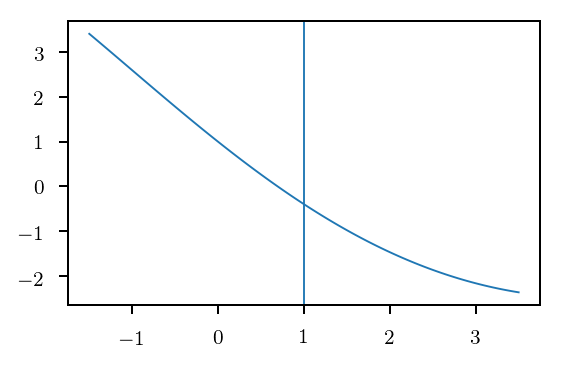

In [49]:
init_plotting(plt)
plt.figure(figsize=set_size('prl'))
#
a, b = g_star.domain
c, r = (a+b)/2, (b-a)/2
Qx_vals = np.linspace(c-r, c+r, 101)
y_vals = g_star(Qx_vals)
plt.plot(Qx_vals, y_vals)
plt.axvline(c)
plt.show()

In [50]:
def G_even(Qx):
    a, b = g_star.domain
    if a < Qx < b:
        return g_star(Qx)
    else:
        alpha = 1/g_star(1)
        return alpha*G_even(G_even(Qx/alpha**2)**2)

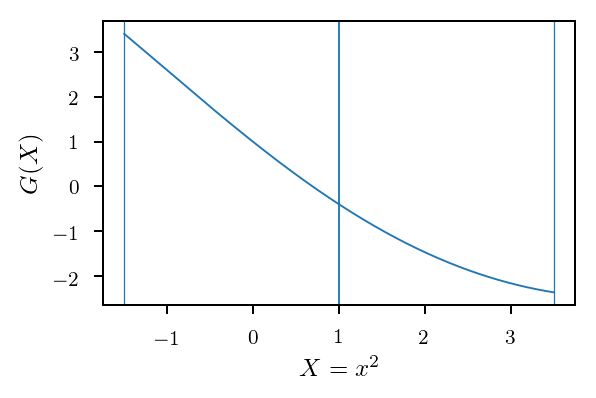

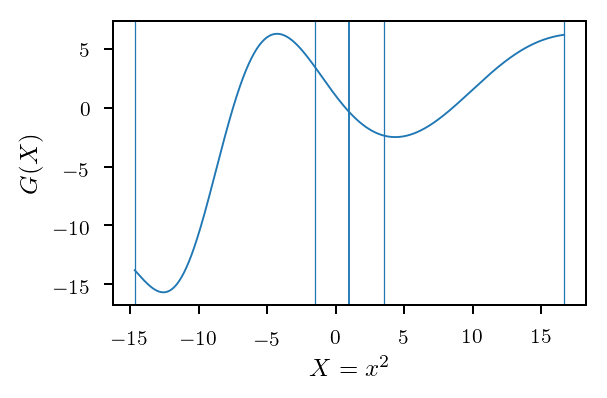

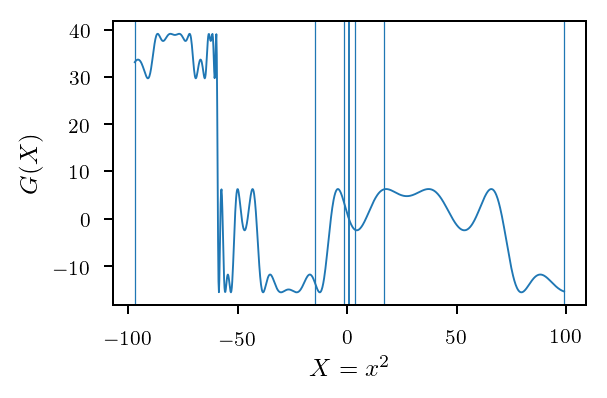

In [51]:
init_plotting(plt)

alpha = 1/G_even(1)
for j in range(0, 3):
    plt.figure(figsize=set_size('prl'))
    x_vals = np.linspace(c-alpha**(2*j)*r, c+alpha**(2*j)*r, 1001)
    y_vals = list(map(G_even, x_vals))
    plt.plot(x_vals, y_vals)
    plt.axvline(c, linestyle='-')
    for k in range(0, j+1):
        plt.axvline(c-r*alpha**(2*k), linestyle='-', linewidth=0.5)
        plt.axvline(c+r*alpha**(2*k), linestyle='-', linewidth=0.5)
    #plt.axvline(0, color='k', linewidth=0.5)
    plt.xlabel(r'$X=x^2$')
    plt.ylabel(r'$G(X)$')
    savefig(plt, 'fig/' + prefix + '_even%d.pdf'%j)
plt.show()

In [52]:
def G_orig(x):
    Qx = x**2
    return G_even(Qx)

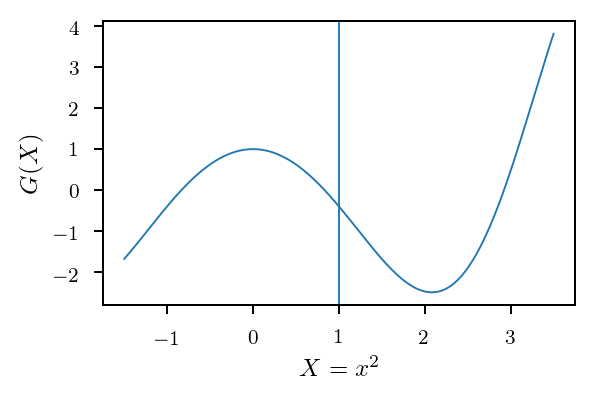

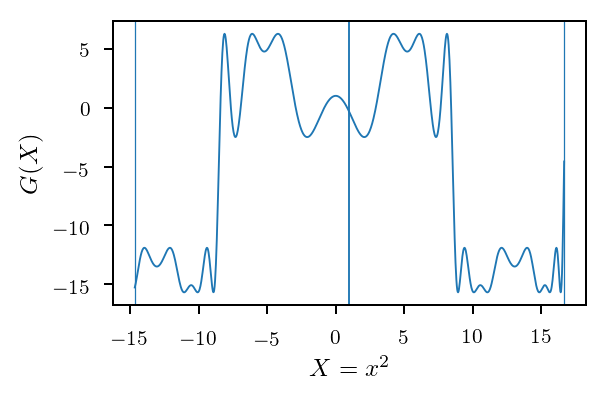

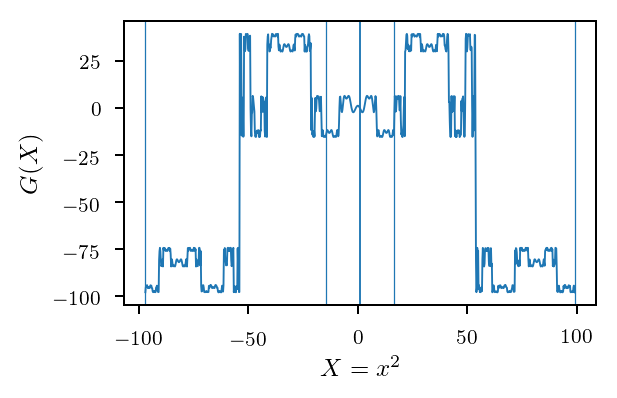

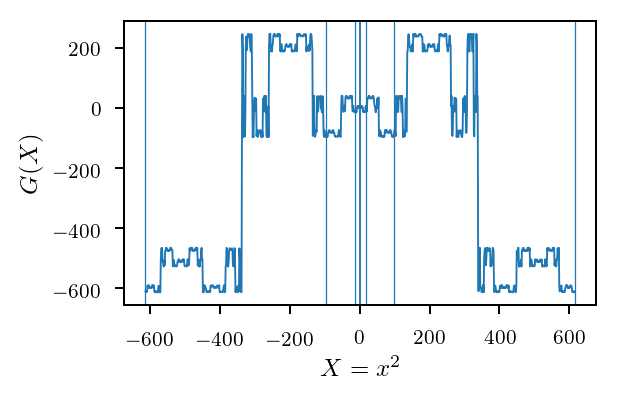

In [53]:
init_plotting(plt)
for j in range(0, 4):
    plt.figure(figsize=set_size('prl'))
    x_vals = np.linspace(c-alpha**(2*j)*r, c+alpha**(2*j)*r, 1001)
    y_vals = list(map(G_orig, x_vals))
    plt.plot(x_vals, y_vals)
    plt.axvline(c, linestyle='-')
    for k in range(1, j+1):
        plt.axvline(c-r*alpha**(2*k), linestyle='-', linewidth=0.5)
        plt.axvline(c+r*alpha**(2*k), linestyle='-', linewidth=0.5)
    #plt.axvline(0, color='k', alpha=0.5)
    plt.xlabel(r'$X=x^2$')
    plt.ylabel(r'$G(X)$')
    #plt.grid(True)
    savefig(plt, 'fig/' + prefix + '_orig%d.pdf'%j)
plt.show()

# Considerations for rigorous proof...

## Domain extension

1.0 2.5


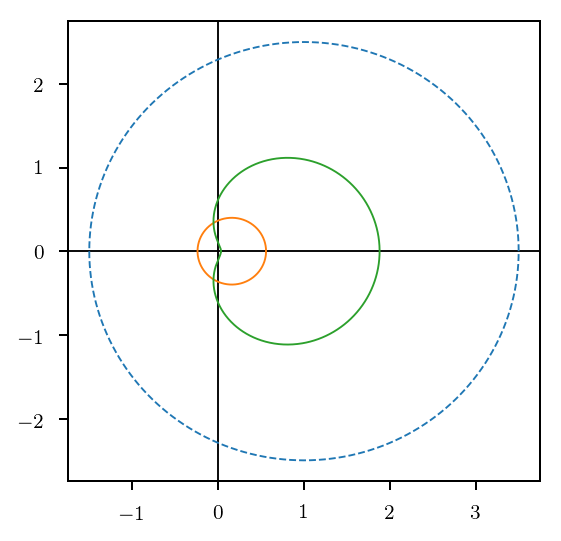

In [54]:
theta = np.linspace(0, 2*np.pi, 1001)
lo, hi = g_star.domain
c, r = (lo+hi)/2, (hi-lo)/2
print(c, r)
x, y = c + r*np.cos(theta), r*np.sin(theta)

Qz = x + y*1j
Qaz = Qz*g_star(1)**2
gQaz = np.fromiter(map(g_star, Qaz), dtype=complex)
QgQaz = gQaz**2

init_plotting(plt)
plt.figure(figsize=set_size('prl', ratio=1))
plt.axhline(0, color='k')
plt.axvline(0, color='k')
#
plt.plot(Qz.real, Qz.imag, linestyle='--', label=r'$Z=z^2$')
plt.plot(Qaz.real, Qaz.imag, label=r'$a^2Z$')
plt.plot(QgQaz.real, QgQaz.imag, label=r'$G(a^2Z)^2$')

#plt.legend(frameon=True, framealpha=1)
savefig(plt, 'fig/' + prefix + '_extension.pdf')
plt.show()

## Function ball composition norm

In [55]:
def check_function_ball_composition(gn, N):
    alpha = 1/gn(1)
    x = make_x(gn)
    lo, hi = gn.domain
    c, r = (lo+hi)/2, (hi-lo)/2
    P0 = gn(x/alpha**2).cutdeg(N)
    print(norm1(P0))
    P1 = (P0**2).cutdeg(N)
    print(norm1(P1))
    P2 = (P1-c)/r
    print(norm1(P2))

    if norm1(P2)<1:
        print('Function ball composition may be well-defined!')
    else:
        print('Doh!')

In [56]:
check_function_ball_composition(g_star, N)

1.3747000325435415
1.8843775000929541
0.6929791055700828
Function ball composition may be well-defined!


## Contractivity of Newton method

### Newton method for fixed points

Newton's method applied to $T-I$ is given by

$$
\mathcal{N}(g)
= I(g) - [DT(g)-I]^{-1}[(T-I)(g)].
$$

Where we have used

$$
DI(g) = I,\quad DI(g)(h) = I(h) = h.
$$

Note that fixed points of $\mathcal{N}$ are exactly those of $T$.

### Adapted Newton method with fixed linear operator

We replace $DT(g)$ with a fixed linear operator $\Delta$, approximating the derivative of $T$, giving

\begin{align}
\Phi(g)
&= I(g) - [\Delta-I]^{-1}[(T-I)(g)]\\
&= I(g) - L[(T-I)(g)].
\end{align}

The purpose of this is to avoid having to take second derivatives of $T$ in the derivative of $\Phi$ below.

Note that, for $L=[\Delta-I]^{-1}$ well-defined, fixed points of $\Phi$ are exactly those of $\mathcal{N}$ and $T$.

### Derivative of adapted Newton method

The derivative is therefore given by

\begin{align}
D\Phi(g)
&= DI(g) - L[DT(g)-DI(g)]\\
&= I - L[DT(g)-I].
\end{align}

Its action on an increment $h$ is given by

$$
D\Phi(g)(h)
= h - L[DT(g)h-h].
$$

In [57]:
def make_Phi(DeltaMinusIInverse):
    def Phi(g):
        Phig_coef = g.coef - DeltaMinusIInverse@(T(g).cutdeg(N).coef-g.coef)
        Phig = Poly1(Phig_coef, domain=g.domain, window=g.window)
        return Phig
    return Phi

In [58]:
basis = make_basis_for(g_star)

In [59]:
I = np.eye(len(g_star))
#Delta = jacobian_approx(T, g_star, basis)
Delta = jacobian_frechet_varin(T, g_star, basis)
Delta

array([[ 8.01553918e+000, -1.34156264e+000,  5.21663083e-001, ...,
         8.17397087e-075, -2.74766906e-075,  9.23625173e-076],
       [ 5.70579610e-001,  2.79660854e+000, -1.22478112e+000, ...,
        -6.18168251e-073,  2.09101205e-073, -7.07276885e-074],
       [-1.02799102e+001, -4.65486193e-001,  1.32456544e-001, ...,
         2.32259234e-071, -7.90603942e-072,  2.69098277e-072],
       ...,
       [ 9.91279221e-099, -1.35112174e-098, -4.15218716e-099, ...,
         4.62990540e-052, -2.55620880e-052,  4.88716528e-053],
       [ 8.74557859e-098,  5.63874874e-099, -4.05223219e-099, ...,
        -2.99504722e-052, -7.03644200e-053,  1.17535210e-052],
       [-1.82981449e-098, -4.28406884e-100,  1.04411305e-099, ...,
        -3.89101714e-052,  2.43347628e-052, -5.59548691e-053]])

In [60]:
DeltaMinusIInverse = np.linalg.inv(Delta - I)
Phi = make_Phi(DeltaMinusIInverse)
Phig = Phi(g_star)

### Approximation to epsilon

We need

$$
\|\Phi(g)-g\|<\epsilon.
$$

This is required to hold only on a (small) ball of functions containing just the single polynomial function $g$ (our approximate fixed point), not on a (large) ball of functions.

In [61]:
epsilon = norm1(Phig-g_star)
epsilon

5.125079123133538e-16

In [62]:
def DPhi_coef(g, DeltaMinusIInverse):
    DTg = DT(g)
    def DPhig_coef(h):
        return h.coef - DeltaMinusIInverse@(DTg(h).cutdeg(N).coef-h.coef)
    return DPhig_coef

In [63]:
DPhig_coef = DPhi_coef(g_star, DeltaMinusIInverse)

In [64]:
DPhi_mat = np.array([DPhig_coef(h) for h in basis]).T
print(DPhi_mat)

[[ 0.00000000e+000 -1.38777878e-017 -1.38777878e-017 ...  0.00000000e+000
  -6.47712642e-078  0.00000000e+000]
 [ 4.44089210e-016  4.44089210e-016  1.11022302e-016 ...  0.00000000e+000
  -3.45446742e-077  0.00000000e+000]
 [ 8.88178420e-016 -1.11022302e-016  3.33066907e-016 ... -2.15904214e-078
   1.51132950e-077  2.15904214e-078]
 ...
 [-3.32653113e-110 -2.53647998e-110  1.24744917e-110 ...  0.00000000e+000
   6.62823411e-095  0.00000000e+000]
 [ 9.31428715e-110  1.62168392e-110 -1.03954098e-110 ...  1.27167221e-094
   0.00000000e+000  0.00000000e+000]
 [-4.15816391e-111 -3.84630161e-111  2.12456187e-111 ...  0.00000000e+000
   0.00000000e+000  0.00000000e+000]]


### Evidence for small kappa

We need

$$
\|D\Phi(g)\|<\kappa.
$$

In actual fact, we need the above bound to hold for all $g$ in a suitable ball of functions.

For the norm, we choose the **maximum column sum norm**.

Here, we estimate $\kappa$ at the approximate fixed point only.  We therefore expect to get an answer that is small to machine precision.

In [65]:
small_kappa = np.max(np.sum(np.abs(DPhi_mat), axis=0))
small_kappa

1.6661593271180629e-15

### Crude bounds on function ball radius

We need

$$
\varepsilon + \kappa\rho < \rho,
$$

thus

$$
\frac{\varepsilon}{1-\kappa} = \rho_\mathrm{min} < \rho.
$$

The above is only heuristic: $\kappa$ is supposed to bound the contractivity of the derivative of the adapted Newton method over the whole ball, not only at $g$.

In [66]:
rho_min = epsilon/(1-small_kappa)
rho_min

5.125079123133547e-16

In [67]:
assert False

AssertionError: 

# Additional materials...

## Eigenfunctions

In [68]:
#DTg = jacobian_approx(T, g_star, basis)
DTg = jacobian_frechet_varin(T, g_star, basis)
vals, vecs_T = np.linalg.eig(DTg)

In [70]:
pairs = zip(vals, vecs_T.T)
def keyfunc(pair):
    a, b = pair
    return abs(a)
sorted_pairs = list(reversed(sorted(pairs, key=keyfunc)))

In [71]:
eigvals, eigvecs = zip(*sorted_pairs)
alpha = 1/g_star(1)
print([alpha**k for k in reversed(range(-2, 3))])
eigvals

[6.264547831217039, -2.502907875095893, 1.0, -0.3995352805231345, 0.15962844038269974]


((6.264547831217029+0j),
 (4.669201609103006+0j),
 (0.15962844038269935+0j),
 (-0.12365271255268671+0j),
 (-0.057307021066681924+0j),
 (0.02548123897901315+0j),
 (-0.010145805672088552+0j),
 (0.004067530437238728+0j),
 (-0.0016252781653665984+0j),
 (0.0006492935399055749+0j),
 (-0.0002587772471663961+0j),
 (0.00010364571512568831+0j),
 (-4.131118010446815e-05+0j),
 (1.6544803857860572e-05+0j),
 (-6.598159256170127e-06+0j),
 (2.6410212362737337e-06+0j),
 (-1.053868006775313e-06+0j),
 (4.2158210096029654e-07+0j),
 (-1.6830116907935258e-07+0j),
 (6.729649327200548e-08+0j),
 (-2.6873666966265238e-08+0j),
 (1.0742434257163544e-08+0j),
 (-4.2906277366334965e-09+0j),
 (1.7147980340964327e-09+0j),
 (-6.849891971028667e-10+0j),
 (2.7373052414967173e-10+0j),
 (-1.0935201087960545e-10+0j),
 (4.369521148373422e-11+0j),
 (-1.7456457929989854e-11+0j),
 (6.974908859944175e-12+0j),
 (-2.78663195594241e-12+0j),
 (1.1135178839872928e-12+0j),
 (-4.448894894697804e-13+0j),
 (1.7766108303971508e-13+0j),
 (

In [72]:
def export_eigensystem(eigvals, eigvecs, filename):
    assert len(eigvals) == len(eigvecs) == len(eigvecs[0])
    with open(filename, 'w') as f:
        f.write(f'{len(eigvals)}\n')
        for val, vec in zip(eigvals, eigvecs):
            f.write(f'{val.real} {val.imag}\n')
            f.write(' '.join(f'{v.real} {v.imag}' for v in vec)+'\n')

In [73]:
export_eigensystem(eigvals, eigvecs, f'dat/feig_even_deg{len(eigvals)-1}_eigen.dat')

In [74]:
Delta == DTg

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

#### Verify the eigensystem

In [75]:
size = len(eigvecs)
eigvecs_cols = np.zeros((size, size), dtype=complex)
for k in range(size):
    eigvecs_cols[:,k] = eigvecs[k]
np.max(np.abs(Delta@eigvecs_cols - np.array(eigvals)*eigvecs_cols))

3.774758283725532e-15

#### Compute and test change of basis to diagonalise the derivative of T

In [76]:
diag_via_eigvecs = np.linalg.inv(eigvecs_cols)@Delta@eigvecs_cols
diag_via_eigvals = np.diag(eigvals)
print(diag_via_eigvals)
np.max(np.abs(diag_via_eigvecs - diag_via_eigvals))

[[ 6.26454783e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  4.66920161e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   1.59628440e-01+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 ...
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j ... -1.87265868e-55+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
  -1.56240763e-56-2.18937201e-56j  0.00000000e+

1.1639997194271175e-08

In [91]:
for k, e in enumerate(eigvals):
    if e.imag != 0:
        print(k, e)
        break

42 (-1.246926322938325e-17-2.9153911157645953e-17j)


In [87]:
(eigvecs_cols[:40,:40].imag == 0).all()

True

In [89]:
diag_via_eigvecs[:4,:4]

array([[ 6.26454783e+00-9.44849383e-18j,  2.23329843e-14-5.07598784e-18j,
         4.65577869e-15+3.39407967e-18j,  8.96314197e-15-3.24928602e-18j],
       [-5.90510160e-15+1.60225479e-17j,  4.66920161e+00+8.20827686e-18j,
        -5.20540813e-15-6.57386903e-18j, -9.78084661e-15+6.22517767e-18j],
       [-6.17552274e-15+7.86167683e-17j, -1.22853187e-14+1.33183628e-16j,
         1.59628440e-01+1.58391202e-16j,  2.40032482e-15-1.35560109e-16j],
       [-1.26016390e-14+3.45617139e-16j, -6.64812663e-15+2.74723927e-16j,
        -4.91068856e-16+5.89875199e-17j, -1.23652713e-01-4.00853964e-17j]])

In [77]:
export_matrix(eigvecs_cols, f'dat/feig_even_deg{len(eigvecs_cols)-1}_domain1_P.dat')

/home/andrewburbanks/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [ ]:
eigfunc = [Poly1(v.real, domain=g_star.domain) for v in eigvecs]

In [ ]:
[p(0) for p in eigfunc]

In [ ]:
E = eigvals[1]
F = eigfunc[1]

norm1(DT(g_star)(F) - E*F)

In [ ]:
# these errors are *much* smaller if we use
# the expression for the frechet derivative
# instead of using the finite-difference
# approximation when making the matrix!

# this is because the properties of DT(g)
# when g happens to be the fixed point are
# special?  that relationship is compromised
# somewhat if we use a finite difference
# approximation?

eigfunc_errors = []
for E, F in zip(eigvals, eigfunc):
    err = norm1(DT(g_star)(F) - E*F)
    eigfunc_errors.append(err)
eigfunc_errors

There would be a much more elegant way to do the following, if we abstracted out the derivative of $G$.

In [ ]:
def make_eigfunc_selfsim(G, E, F):
    lo, hi = F.domain
    def DG(X):
        eps = 1e-5
        return (G(X+eps)-G(X-eps))/(2*eps)
    def func(X):
        alpha = 1/G(1)
        if lo < X < hi:
            return F(X)
        else:
            dg = DG
            g = G
            h = func
            x = X
            #
            alpha = 1/g(1)
            dalpha = -1/g(1)**2*h(1)
            #
            Dg0 = dalpha*g(g(x/alpha**2)**2)
            Dg1 = alpha*h(g(x/alpha**2)**2)
            Dg2 = alpha*dg(g(x/alpha**2)**2)*2*g(x/alpha**2)*h(x/alpha**2)
            Dg3 = alpha*dg(g(x/alpha**2)**2)*2*g(x/alpha**2)*dg(x/alpha**2)*(-2*x/alpha**3*dalpha)
            #
            return (Dg0+Dg1+Dg2+Dg3)/E
    return func

In [ ]:
from itertools import islice

In [ ]:
# the function applied to X
# seems much more revealing
# than that applied to x.

k = 1
E = eigvals[k]
F = eigfunc[k]
print(E)
print(F)
assert(norm1(E.imag) < 1e-15)
E = E.real
FF = make_eigfunc_selfsim(G_even, E, F)

init_plotting(plt)
plt.figure(figsize=set_size('prl'))
#plt.yscale('symlog')
X = np.linspace(0, 256, 257)
Y = np.fromiter(map(FF, X), dtype=float)
plt.plot(X, Y)
plt.figure()
#plt.yscale('symlog')
x = np.linspace(-16, 16, 257)
X = x**2
Y = np.fromiter(map(FF, X), dtype=float)
plt.plot(x, Y)
plt.show()